In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import datetime as dt


from tensorflow.keras.layers import Dense, Dropout
from keras.layers import GRU
from keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
main_dataset1 = pd.read_csv("HDFCBANK.csv") #Read the data

In [3]:
main_dataset1.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,HDFCBANK,EQ,157.40,166.00,170.00,166.00,170.00,170.00,169.52,33259,5.638122e+11,NaN,NaN,NaN
1,2000-01-04,HDFCBANK,EQ,170.00,182.00,183.45,171.00,174.00,173.80,174.99,168710,2.952261e+12,NaN,NaN,NaN
2,2000-01-05,HDFCBANK,EQ,173.80,170.00,173.90,165.00,168.00,166.95,169.20,159820,2.704094e+12,NaN,NaN,NaN
3,2000-01-06,HDFCBANK,EQ,166.95,168.00,170.00,165.30,168.95,168.30,168.44,85026,1.432166e+12,NaN,NaN,NaN
4,2000-01-07,HDFCBANK,EQ,168.30,162.15,171.00,162.15,170.75,168.35,166.79,85144,1.420158e+12,NaN,NaN,NaN


In [4]:
# Extracting date and total confirmed cases columns
date_column = 'Date'  # Assuming 'Date' is the column name for date
high = 'High'  # Assuming 'Total Confirmed cases' is the column name for confirmed cases

# Selecting only the columns of interest
main_dataset = main_dataset1[[date_column, high]]

# Displaying the selected data
print(main_dataset)

            Date     High
0     2000-01-03   170.00
1     2000-01-04   183.45
2     2000-01-05   173.90
3     2000-01-06   170.00
4     2000-01-07   171.00
...          ...      ...
5301  2021-04-26  1429.00
5302  2021-04-27  1442.00
5303  2021-04-28  1479.00
5304  2021-04-29  1503.65
5305  2021-04-30  1453.80

[5306 rows x 2 columns]


In [7]:
main_dataset['High'] = main_dataset['High'].astype(int)

<ipython-input-7-1c4b789cbbf4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_dataset['High'] = main_dataset['High'].astype(int)


In [8]:
main_dataset

,Date,High
0,2000-01-03,170
1,2000-01-04,183
2,2000-01-05,173
3,2000-01-06,170
4,2000-01-07,171
...,...,...
5301,2021-04-26,1429
5302,2021-04-27,1442
5303,2021-04-28,1479
5304,2021-04-29,1503


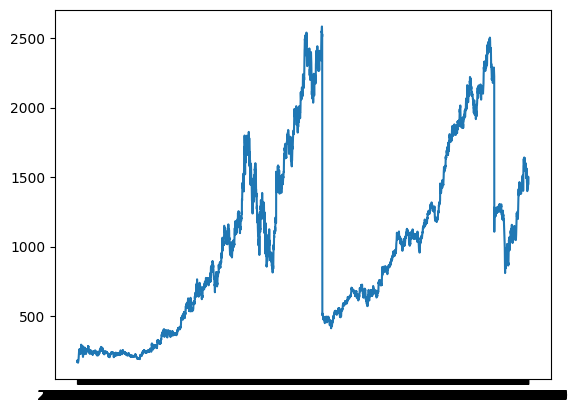

In [10]:
plt.plot(main_dataset.Date,main_dataset.High)
plt.show()

In [11]:
dataset = main_dataset #Create another dataset same as the main dataset. Just to avoid replacing the main one.
dataset = dataset.set_index('Date') #Set the index of the dataset as the date
dataset = dataset['High'] #We will be left with only one column Cases for our datase

In [12]:
dataset=dataset.to_frame() #Convert the Series into a dataframe object
dataset['Cases_MA2']=dataset.expanding(min_periods=3).mean()

In [13]:
dataset['EMA'] = dataset.iloc[:,0].ewm(span=3,adjust=False).mean()

In [14]:
dataset = dataset[dataset['Cases_MA2'].notna()]

In [15]:
dataset.head()

,High,Cases_MA2,EMA
Date,,,
2000-01-05,173,175.333333,174.750000
2000-01-06,170,174.000000,172.375000
2000-01-07,171,173.400000,171.687500
2000-01-10,179,174.333333,175.343750
2000-01-11,167,173.285714,171.171875


In [16]:
#Cases is the column we have to predict.
target=dataset[['High']]
del dataset['High']

In [17]:
x, y = dataset.values, target.values

In [18]:
x.shape

(5304, 2)

In [19]:
y.shape

(5304, 1)

In [28]:
x_scaled_set = MinMaxScaler() #Use MinMaxScaler function from sklearn.preprocessing library
y_scaled_set = MinMaxScaler()

X = x_scaled_set.fit_transform(x) #Fit to data and transform the data array x
Y = y_scaled_set.fit_transform(y.reshape(-1,1))

In [29]:
x.shape

(5304, 2)

In [30]:
X_train_data=X[0:5000,]
y_train_data=Y[0:5000,]
X_test_data=X[5000:5304,]
y_test_data=Y[5000:5304,]

In [31]:
X_train_data.shape

(5000, 2)

In [27]:
y_test_data.shape

(304, 1)

In [32]:
X_train_data = X_train_data.reshape((-1,1,2)) #Reshape train dataset to required format
X_test_data = X_test_data.reshape((-1,1,2)) #Reshape test dataset to required format

## RNN-GRU MODEL

In [33]:
GRU_model = Sequential() #Use Sequential function from keras.model library
GRU_model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(1, 2))) #Add GRU model with 512 units. Note that return sequences should be true to pass on the sequences. Ensure that input_shape is inline with the inout data.
GRU_model.add(Dropout(0.2)) #Add a dropout layer to avoid overfitting.
GRU_model.add(GRU(units=256)) #Add another GRU layer with 256 units.
GRU_model.add(Dropout(0.2)) #Add another dropout layer to avoid overfitting.
GRU_model.add(Dense(1, activation='sigmoid')) #Finally, add a dense layer for getting a fully connected layer.


In [34]:
GRU_model.compile(loss='mse', optimizer='adam', metrics = ['accuracy'])

In [35]:
GRU_model.fit(X_train_data,y_train_data,batch_size=250, epochs=100, validation_split=0.15, verbose=1)
#GRU_model.save("covid_GRU.h5") #Save the model if you want for reuse.

Epoch 1/100
17/17 [==============================] - 5s 91ms/step - loss: 0.0746 - accuracy: 4.7059e-04 - val_loss: 0.1738 - val_accuracy: 0.0000e+00
Epoch 2/100
17/17 [==============================] - 1s 47ms/step - loss: 0.0228 - accuracy: 4.7059e-04 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 3/100
17/17 [==============================] - 1s 61ms/step - loss: 0.0019 - accuracy: 7.0588e-04 - val_loss: 0.0108 - val_accuracy: 0.0000e+00
Epoch 4/100
17/17 [==============================] - 1s 53ms/step - loss: 0.0018 - accuracy: 7.0588e-04 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 5/100
17/17 [==============================] - 1s 44ms/step - loss: 0.0011 - accuracy: 7.0588e-04 - val_loss: 8.8163e-04 - val_accuracy: 0.0000e+00
Epoch 6/100
17/17 [==============================] - 1s 43ms/step - loss: 0.0011 - accuracy: 7.0588e-04 - val_loss: 0.0018 - val_accuracy: 0.0000e+00
Epoch 7/100
17/17 [==============================] - 1s 44ms/step - loss: 0.0011 - accuracy: 7.0

In [36]:
score = GRU_model.evaluate(X_test_data, y_test_data) #Evaluate model can be used to get the loss metric.
print('Score: {}'.format(score))
y_pred = GRU_model.predict(X_test_data) #Apply the built model on test data.
y_test_pred = y_scaled_set.inverse_transform(y_pred) #Use inverse transform to undo the scaling that was done before. This gives us the original values.
y_test_actual = y_scaled_set.inverse_transform(y_test_data) # Apply the inverse transform on the actual dataset for easy comparison of predicted vs actual.
#plt.plot(y_test_pred[-100:], label='Predicted') #Plot the predicted vs actual graph
#plt.plot(y_test_actual[-100:], label='Actual')
#plt.legend()
#plt.show()

10/10 [==============================] - 1s 10ms/step - loss: 1.2977e-04 - accuracy: 0.0000e+00
Score: [0.00012977146252524108, 0.0]
10/10 [==============================] - 2s 12ms/step


In [37]:
test_Dates=main_dataset.Date[5000:5304] #create an object which has the dates for the Test data.

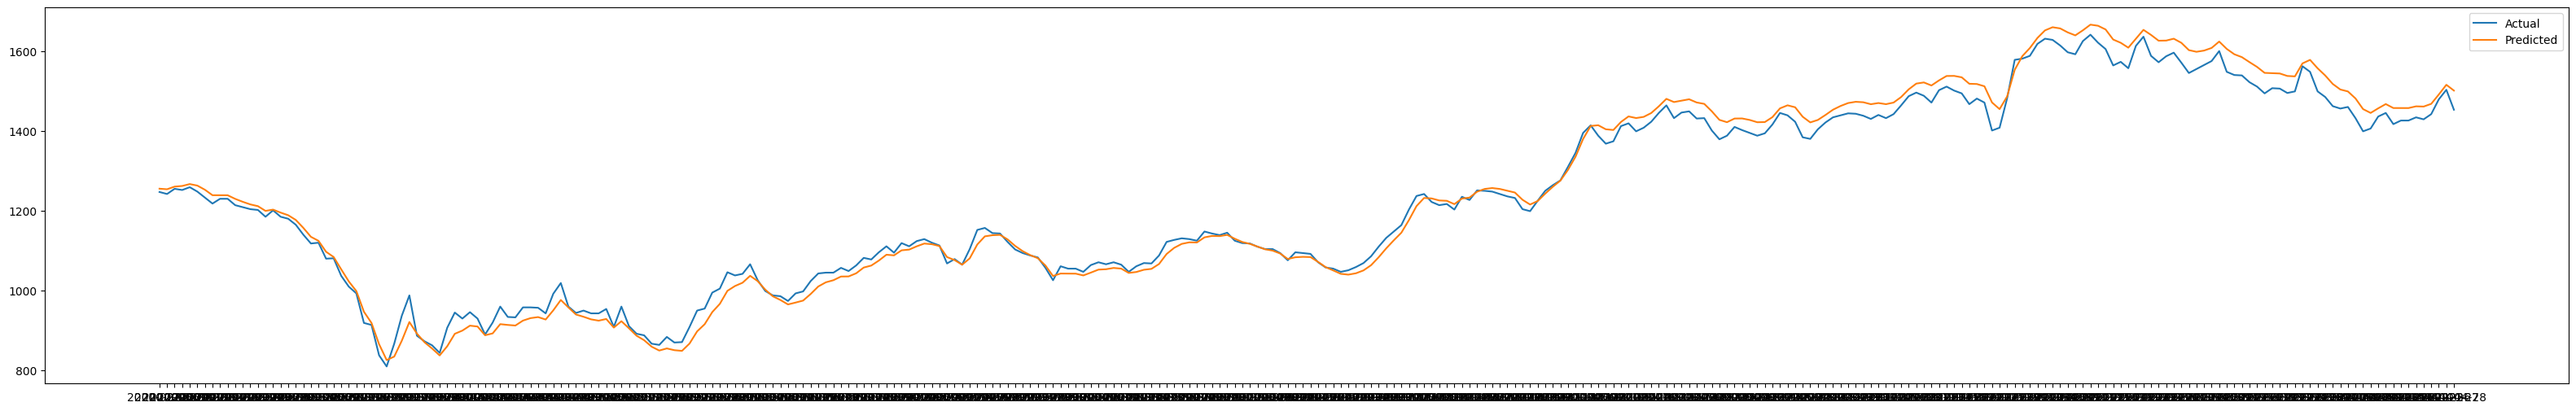

In [44]:

# Define the figure size
fig_size = (40, 6)  # Adjust width and height as needed

# Create a new figure with the specified size
plt.figure(figsize=fig_size)

# Assuming test_Dates, y_test_actual, and y_test_pred are already defined

# Plot actual and predicted data
plt.plot(test_Dates, y_test_actual[-690:], label='Actual')
plt.plot(test_Dates, y_test_pred[-690:], label='Predicted')

# Add legend
plt.legend()

# Show the plot
plt.show()